In [149]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


In [338]:
#data_ contains the label information: "Dead" and "Alive"
data_ = pd.read_csv('clinical_data.csv').drop(columns=['case_id'])

In [340]:
data_.head()

,ajcc_pathologic_stage,days_to_last_follow_up,primary_diagnosis,prior_malignancy,year_of_diagnosis,prior_treatment,pharm_treatment,radiation,ethnicity,race,vital_status,age_at_index,year_of_birth
0,1,337.0,Infilt...,no,2010.0,No,1,0,not hi...,white,Alive,60,1950.0
1,3,5.0,Infilt...,no,2010.0,No,0,0,not hi...,white,Alive,56,1954.0
2,1,759.0,Lobula...,yes,2012.0,No,1,0,not hi...,white,Alive,61,1951.0
3,5,954.0,Lobula...,yes,2010.0,No,1,1,not hi...,white,Alive,71,1939.0
4,8,304.0,Infilt...,no,2009.0,No,1,0,not re...,not re...,Alive,76,1933.0


In [342]:
#hot_encoded data
hot_data = pd.read_csv('one_hot_encoded_data.csv').drop(columns=['year_of_diagnosis', 'year_of_birth'])
#hot_data.info()

In [249]:
#hot_data = hot_data)

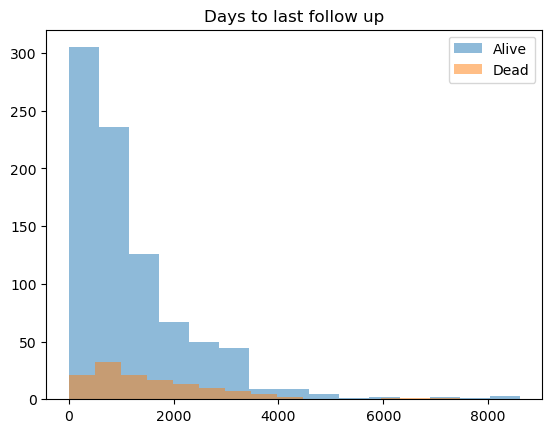

In [343]:
x = data_.loc[data_['vital_status']=='Alive','days_to_last_follow_up']
y = data_.loc[data_['vital_status']=='Dead','days_to_last_follow_up']
bins=15
pyplot.hist(x, bins=bins, alpha=0.5, label='Alive')
pyplot.hist(y, bins=bins, alpha=0.5, label='Dead')
pyplot.legend(loc='upper right')
pyplot.title ('Days to last follow up')
pyplot.show()

In [344]:
print(np.mean(x))
print(np.mean(y))

1196.8918604651162
1622.5954198473282


In [365]:
#Dictionary with Dataframe for fitting models later
#Data[i]['df'] is the dataframe with features
#Data[i]['y'] is the label

#no_days= [360,720,1440,2880,4320]
no_days= [365,730,1095,1460,1825]
Data= {}
for i in no_days:
    index = data_.loc[data_['vital_status']=='Alive'].loc[data_['days_to_last_follow_up']<i].index
    df = hot_data.drop(index=index)
    data_temp = data_.drop(index=index)
    y = (data_temp['days_to_last_follow_up']<=i)*1
    Data[i] = {}
    Data[i]['df']= df.copy()
    Data[i]['y']= y.copy()

In [366]:
#Code to see how many people died within the first year.
for i in no_days:
    print(f"Days: {i}   Dead: {np.sum(Data[i]['y'])}   Alive: {Data[i]['y'].shape[0]}")

Days: 365   Dead: 23   Alive: 854
Days: 730   Dead: 34   Alive: 585
Days: 1095   Dead: 60   Alive: 465
Days: 1460   Dead: 73   Alive: 378
Days: 1825   Dead: 87   Alive: 317


In [367]:
#Add models 

random.seed(123)

#dictionary = {}

acc = {}
prec = {}
rec = {}
CM = {}

models = {'rf': RandomForestClassifier(n_estimators=10),
                  'svc': SVC()
                 }

for timeframe in Data.keys():
# first split data into train and test
    xtrain_, xtest, ytrain_, ytest = train_test_split(Data[timeframe]['df'], Data[timeframe]['y'], train_size=0.8, stratify = Data[timeframe]['y'], shuffle=True, random_state=123)
    # scale data
    scale = MinMaxScaler()
    xtrain_temp = scale.fit_transform(xtrain_)
    xtrain = pd.DataFrame(xtrain_temp, index=xtrain_.index, columns=xtrain_.columns)

    xtest = scale.transform(xtest)
    
    # perform stratified k-fold to split xtrain_ into xtrain_train and validation sets
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    
#    dictionary[timeframe] = {}

    model_scores = []
    
    acc[timeframe] = []
    prec[timeframe] = []
    rec[timeframe] = []
    CM[timeframe] = []

    # Perform stratified k-fold split with nested validation set
    for fold, (train_idx, val_idx) in enumerate(skf.split(xtrain_, ytrain_)):

#        xtrain_train = xtrain_.iloc[train_idx, :]
#        ytrain_train = ytrain_[train_idx]
#        print(ytrain_train)


        xtrain_train, ytrain_train = xtrain_.iloc[train_idx], ytrain_.iloc[train_idx]

        xval, yval = xtrain_.iloc[val_idx], ytrain_.iloc[val_idx]

        # Train multiple models
        models = {'rf': RandomForestClassifier(),
                  'svc': SVC()
                 } # decisiontreeclassifier is our base model, thus we compare our results to this model.

        for model_name in models.keys():
            # Train the model
            model.fit(xtrain_train, ytrain_train)
#            print(np.sum(ytrain_train))
            # Validate the model
            val_predictions = model.predict(xval)
#            print(np.sum(val_predictions))
#            print(np.sum(yval))

#            print(np.sum(val_predictions))
            acc_val = accuracy_score(yval, val_predictions)
            prec_val = precision_score(yval, val_predictions)
            rec_val = recall_score(yval, val_predictions)
            CM_val = confusion_matrix(yval, val_predictions)

            #print(f"Fold {fold + 1}, Model: {model_name}, Validation Accuracy: {val_score:.4f}")

            acc[timeframe].append((model_name, acc_val))
            prec[timeframe].append((model_name, prec_val))
            rec[timeframe].append((model_name, rec_val))
            CM[timeframe].append((model_name, CM_val))
            
#    dictionary[timeframe]['ms']= model_scores

/Users/karlapaulette/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlapaulette/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlapaulette/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlapaulette/opt/anaconda3/lib/python3.9/site-pack

In [368]:
models = {'rf': RandomForestClassifier(random_state=123),
                  'svc': SVC()
                 }
models.keys()

dict_keys(['rf', 'svc'])

In [369]:
# Calculate average validation accuracy for each model and find the best model
for timeframe in no_days:
    for model_name in models.keys():
        average_model_scores = {model_name: np.mean(scores[1]) for scores in acc[timeframe] if scores[0]==model_name}
        best_model_name = max(average_model_scores, key=average_model_scores.get)
        best_model_avg_score = average_model_scores[best_model_name]

    print(f"Best Model: {best_model_name} for survival prediction after {timeframe} days with average accuracy: {best_model_avg_score:.4f}")

Best Model: svc for survival prediction after 365 days with average accuracy: 0.9779
Best Model: svc for survival prediction after 730 days with average accuracy: 0.9892
Best Model: svc for survival prediction after 1095 days with average accuracy: 0.9730
Best Model: svc for survival prediction after 1460 days with average accuracy: 0.9833
Best Model: svc for survival prediction after 1825 days with average accuracy: 0.9600


In [370]:
# Calculate average validation precision for each model and find the best model
for timeframe in no_days:
    for model_name in models.keys():
        average_model_scores = {model_name: np.mean(scores[1]) for scores in rec[timeframe] if scores[0]==model_name}
        best_model_name = max(average_model_scores, key=average_model_scores.get)
        best_model_avg_score = average_model_scores[best_model_name]

    print(f"Best Model: {best_model_name} for survival prediction after {timeframe} days with average recall: {best_model_avg_score:.4f}")

Best Model: svc for survival prediction after 365 days with average recall: 0.0000
Best Model: svc for survival prediction after 730 days with average recall: 0.8000
Best Model: svc for survival prediction after 1095 days with average recall: 0.8000
Best Model: svc for survival prediction after 1460 days with average recall: 0.9167
Best Model: svc for survival prediction after 1825 days with average recall: 0.8571


In [371]:
# Calculate average validation recall for each model and find the best model
for timeframe in no_days:
    for model_name in models.keys():
        average_model_scores = {model_name: np.mean(scores[1]) for scores in prec[timeframe] if scores[0]==model_name}
        best_model_name = max(average_model_scores, key=average_model_scores.get)
        best_model_avg_score = average_model_scores[best_model_name]

    print(f"Best Model: {best_model_name} for survival prediction after {timeframe} days with average precision: {best_model_avg_score:.4f}")

Best Model: svc for survival prediction after 365 days with average precision: 0.0000
Best Model: svc for survival prediction after 730 days with average precision: 1.0000
Best Model: svc for survival prediction after 1095 days with average precision: 1.0000
Best Model: svc for survival prediction after 1460 days with average precision: 1.0000
Best Model: svc for survival prediction after 1825 days with average precision: 1.0000


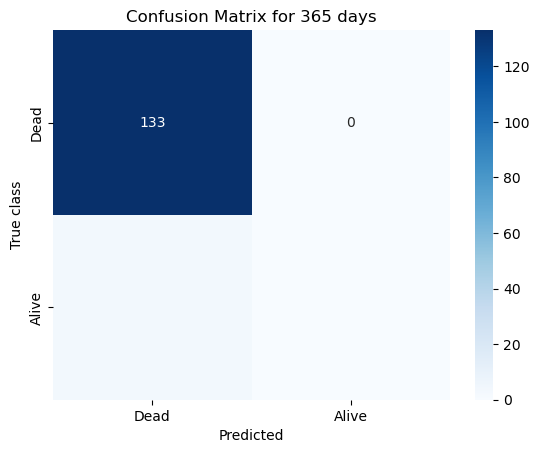

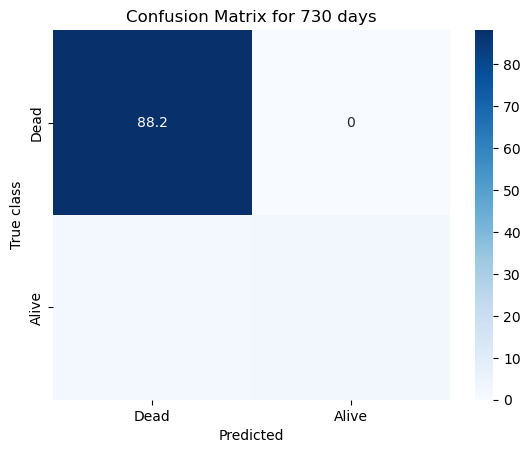

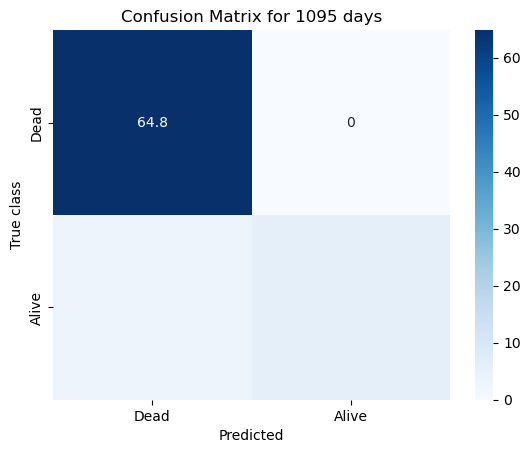

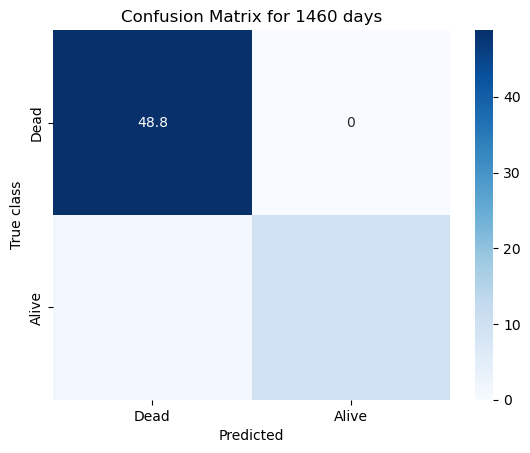

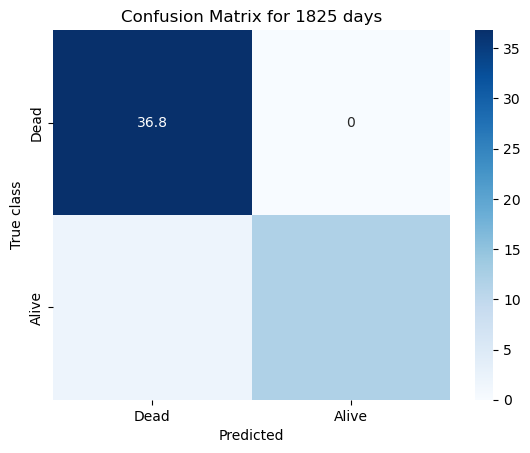

In [382]:
# Confusion matrix

for timeframe in no_days:
    CMs = [scores[1] for scores in CM[timeframe] if scores[0]=='svc']
    CM_mean = np.mean(CMs, axis=0)   
    plott = pd.DataFrame(CM_mean, index = ['Dead','Alive'],
                      columns = ['Dead','Alive'])
    sns.heatmap(plott, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True class')
    plt.title(f"Confusion Matrix for {timeframe} days")
    plt.show()
#    plt.savefig('conf_m_{}'.format(days)+'.png')
#    plt.clf()
